Samara Holmes

Detecting glass walls using only monocular information

# Use the GW-Depth Dataset

Paper: Monocular Depth Estimation for Glass Walls With Context

GitHub: https://github.com/ViktorLiang/GW-Depth

In [ ]:
"""
The GW-Depth dataset can be downloaded from:
https://drive.google.com/drive/folders/1hY34sFkJz56WYdvGHaSlWlOW5ufyc-M8?usp=drive_link

The dataset includes:
- RGB images with glass walls
- Depth annotations for glass surfaces
- Glass segmentation masks
- Instance-level line segments of glass edges
"""

import os
import numpy as np
import cv2
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
import gdown  # For downloading from Google Drive


class GWDepthDataset:
    """
    DataLoader for GW-Depth Dataset
    """
    def __init__(self, root_dir, split='train', use_depth_camera=False, transform=None):
        """
        Args:
            root_dir (str): Root directory of the dataset
            split (str): 'train', 'val', or 'test' (if applicable)
            use_depth_camera (bool): Whether to use depth_camera instead of depth folder
            transform: Optional transform to be applied on samples
        """
        self.root_dir = Path(root_dir)
        self.split = split
        self.transform = transform
        self.use_depth_camera = use_depth_camera
        
        # Check if dataset has train/val/test splits or direct folders
        if (self.root_dir / split).exists():
            # Dataset has splits
            self.base_dir = self.root_dir / split
        else:
            # Dataset doesn't have splits, use root directly
            self.base_dir = self.root_dir
            print(f"No split folders found, using root directory directly")
        
        # Define paths for different data types with new folder names
        self.rgb_dir = self.base_dir / 'images'  # Changed from 'rgb' to 'images'
        
        # Choose which depth folder to use
        if use_depth_camera:
            self.depth_dir = self.base_dir / 'depth_camera'
            print("Using depth_camera folder for depth maps")
        else:
            self.depth_dir = self.base_dir / 'depth'
            print("Using depth folder for depth maps")
            
        self.segmentation_dir = self.base_dir / 'segmentation'  # Changed from 'glass_mask' to 'segmentation'
        
        # Check which directories exist
        print(f"\nChecking directory structure in: {self.base_dir}")
        print(f"  Images directory exists: {self.rgb_dir.exists()}")
        print(f"  Depth directory exists: {self.depth_dir.exists()}")
        print(f"  Segmentation directory exists: {self.segmentation_dir.exists()}")
        
        # Get list of images
        self.image_list = []
        if self.rgb_dir.exists():
            # Try different image extensions
            for ext in ['*.png', '*.jpg', '*.jpeg', '*.PNG', '*.JPG', '*.JPEG']:
                self.image_list.extend(list(self.rgb_dir.glob(ext)))
            self.image_list = sorted(self.image_list)
        
        if len(self.image_list) == 0:
            raise ValueError(f"No images found in {self.rgb_dir}")
        
        print(f"\nFound {len(self.image_list)} images")
        print(f"  First few images: {[img.name for img in self.image_list[:3]]}")
    
    def __len__(self):
        return len(self.image_list)

## Train on the dataset

In [ ]:
class GWDepthTransform:
    """
    Transform class for preprocessing GW-Depth data
    """
    def __init__(self, resize_size=(480, 640), normalize=True):
        self.resize_size = resize_size
        self.normalize = normalize
        
        # Standard ImageNet normalization
        self.rgb_normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    
    def __call__(self, sample):
        rgb = sample['rgb']
        
        # Resize RGB (PIL expects width, height)
        rgb = rgb.resize((self.resize_size[1], self.resize_size[0]), Image.BILINEAR)
        
        # Convert to tensor
        rgb_tensor = transforms.ToTensor()(rgb)
        
        # Normalize if required
        if self.normalize:
            rgb_tensor = self.rgb_normalize(rgb_tensor)
        
        # Process depth if available
        if sample['depth'] is not None:
            depth = sample['depth']
            depth = cv2.resize(depth, (self.resize_size[1], self.resize_size[0]), 
                             interpolation=cv2.INTER_NEAREST)
            depth_tensor = torch.from_numpy(depth).unsqueeze(0)
        else:
            depth_tensor = None
        
        # Process segmentation mask if available
        if sample['segmentation'] is not None:
            mask = sample['segmentation']
            mask = cv2.resize(mask, (self.resize_size[1], self.resize_size[0]), 
                            interpolation=cv2.INTER_NEAREST)
            mask_tensor = torch.from_numpy(mask).unsqueeze(0).float()
        else:
            mask_tensor = None
        
        return {
            'rgb': rgb_tensor,
            'depth': depth_tensor,
            'segmentation': mask_tensor,
            'filename': sample['filename']
        }

## Visualize

In [ ]:
def visualize_sample(sample, save_path=None):
    """
    Visualize a sample from the dataset
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # RGB image
    rgb = sample['rgb']
    if isinstance(rgb, torch.Tensor):
        # Denormalize if normalized
        rgb = rgb.cpu().numpy().transpose(1, 2, 0)
        rgb = (rgb * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        rgb = np.clip(rgb, 0, 1)
    else:
        rgb = np.array(rgb) / 255.0
    
    axes[0, 0].imshow(rgb)
    axes[0, 0].set_title('RGB Image')
    axes[0, 0].axis('off')
    
    # Depth map
    if sample['depth'] is not None:
        depth = sample['depth']
        if isinstance(depth, torch.Tensor):
            depth = depth.cpu().numpy().squeeze()
        
        # Apply colormap for better visualization
        depth_vis = plt.cm.viridis(depth / depth.max())
        axes[0, 1].imshow(depth_vis)
        axes[0, 1].set_title('Depth Map')
        axes[0, 1].axis('off')
    
    # Glass mask
    if sample['glass_mask'] is not None:
        mask = sample['glass_mask']
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy().squeeze()
        
        axes[1, 0].imshow(mask, cmap='gray')
        axes[1, 0].set_title('Glass Mask')
        axes[1, 0].axis('off')
    
    # Overlay visualization
    if sample['glass_mask'] is not None:
        # Create overlay of glass regions on RGB
        overlay = rgb.copy()
        if isinstance(sample['glass_mask'], torch.Tensor):
            mask = sample['glass_mask'].cpu().numpy().squeeze()
        else:
            mask = sample['glass_mask']
        
        # Highlight glass regions in blue
        overlay[:, :, 2] = np.where(mask > 0, 1.0, overlay[:, :, 2])
        overlay[:, :, 0] = np.where(mask > 0, 0.5 * overlay[:, :, 0], overlay[:, :, 0])
        
        axes[1, 1].imshow(overlay)
        axes[1, 1].set_title('Glass Overlay on RGB')
        axes[1, 1].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()

## Go Thru Dataset

In [9]:
# 1. Set dataset path
dataset_path = 'AFR-Final-Project/Detecting Glass Walls/Camera/Glass-RGBD-Dense'  # Update with your actual path

print(f"Using dataset path: {dataset_path}")


# 2. Create dataset instance
transform = GWDepthTransform(resize_size=(480, 640))
dataset = GWDepthDataset(
    root_dir=dataset_path,
    split='train',
    transform=transform
)

# 3. Create DataLoader for batch processing
from torch.utils.data import DataLoader

dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=2
)

# 4. Iterate through batches
for i, batch in enumerate(dataloader):
    rgb_batch = batch['rgb']
    depth_batch = batch['depth']
    mask_batch = batch['glass_mask']
    
    print(f"Batch {i}:")
    print(f"  RGB shape: {rgb_batch.shape}")
    if depth_batch is not None:
        print(f"  Depth shape: {depth_batch.shape}")
    if mask_batch is not None:
        print(f"  Mask shape: {mask_batch.shape}")
    
    # Visualize first sample in batch
    if i == 0:
        sample = {
            'rgb': rgb_batch[0],
            'depth': depth_batch[0] if depth_batch is not None else None,
            'glass_mask': mask_batch[0] if mask_batch is not None else None
        }
        visualize_sample(sample)
    
    # Process only first batch for demo
    break

Using dataset path: AFR-Final-Project/Detecting Glass Walls/Camera/Glass-RGBD-Dense
Found 0 images in train split


ValueError: num_samples should be a positive integer value, but got num_samples=0

# Use the PTH File
The PTH file contains the weights, so we need to load that but also re-create the architecture that is used in GW-Depth.

## Load the PTH

In [26]:
import torch

MODEL_PATH = "./checkpoint0100.pth"

try:
    checkpoint = torch.load(MODEL_PATH, map_location='cpu', weights_only=False)  # or 'cuda' if using GPU
    print("Checkpoint PTH loaded successfully.")
except FileNotFoundError:
    print("[Error] Checkpoint PTH file not found. Check the path.")
except Exception as e:
    print(f"[Error] Failed to load checkpoint PTH: {e}")

Checkpoint PTH loaded successfully.


## Load the test dataset

In [11]:
DATASET_DIR = "./test_images"

In [ ]:
import os
import sys
import numpy as np
import cv2
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')


def setup_gw_depth_environment(dataset_dir):
    """
    Setup the environment for GW-Depth dataset and model
    
    Args:
        dataset_dir: Path to the unzipped dataset directory
    """
    dataset_dir = Path(dataset_dir)
    
    # Check dataset
    if dataset_dir.exists():
        print(f"Dataset directory found: {dataset_dir}")
        
        # List contents of dataset directory
        contents = list(dataset_dir.iterdir())
        print(f"  Contents: {[d.name for d in contents[:5]]}...")
        
        # Check for common subdirectories
        possible_structures = [
            ['train', 'val', 'test'],
            ['training', 'validation', 'testing'],
            ['rgb', 'depth', 'mask'],
            ['images', 'depths', 'masks']
        ]
        
        found_structure = None
        for structure in possible_structures:
            if any((dataset_dir / folder).exists() for folder in structure):
                found_structure = structure
                break
        
        if found_structure:
            print(f"Dataset structure detected: {found_structure}")
    else:
        print(f"Dataset directory not found: {dataset_dir}")
        return False
    
    return True

class GWDepthDatasetLoader:
    """
    DataLoader that adapts to different dataset structures
    """
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir: Root directory of the dataset
            transform: Optional transform to be applied
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []
        
        print(f"\nScanning dataset structure in: {self.root_dir}")
        
        # Try load from root
        self._load_from_root()
        
        if len(self.samples) == 0:
            raise ValueError("No valid samples found in the dataset directory")
        
        print(f"Loaded {len(self.samples)} samples")
    
    
    def _load_from_root(self):
        """Load image files directly from root"""
        image_files = list(self.root_dir.glob('*.jpg')) + list(self.root_dir.glob('*.png'))
        for img_path in image_files[:100]:
            self.samples.append({
                'rgb_path': img_path,
                'depth_path': None,
                'mask_path': None,
                'split': 'root'
            })
    
    def __len__(self):
        return len(self.samples)
    

class GWDepthModel:
    """
    Wrapper for GW-Depth pretrained model, simplified for loading and inference
    """
    def __init__(self, model_path, device='cuda'):
        """
        Args:
            model_path: Path to the .pth file
            device: Device to run the model on
        """
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        print(f"\nLoading model on device: {self.device}")
        
        self.model_path = Path(model_path)
        
        # Load the checkpoint
        self.checkpoint = torch.load(self.model_path, map_location=self.device, weights_only=False)
        
        # Analyze checkpoint structure
        self._analyze_checkpoint()
        
        # Try to load the model
        self.model = self._load_model()
        
        if self.model:
            self.model.eval()
            print("Model loaded successfully")
    
    def _analyze_checkpoint(self):
        """Analyze the checkpoint structure"""
        print("\nCheckpoint Analysis:")
        
        if isinstance(self.checkpoint, dict):
            print(f"  Checkpoint keys: {list(self.checkpoint.keys())[:5]}")
            
            # Common keys in checkpoints
            if 'model' in self.checkpoint:
                print("  Found 'model' key")
            if 'state_dict' in self.checkpoint:
                print("  Found 'state_dict' key")
            if 'model_state_dict' in self.checkpoint:
                print("  Found 'model_state_dict' key")
            if 'epoch' in self.checkpoint:
                print(f"  Epoch: {self.checkpoint['epoch']}")
            if 'best_acc' in self.checkpoint or 'best_loss' in self.checkpoint:
                best_metric = self.checkpoint.get('best_acc', self.checkpoint.get('best_loss'))
                print(f"  Best metric: {best_metric}")
        else:
            print("  Checkpoint is a state_dict (not wrapped in dictionary)")
    
    def _load_model(self):
        """
        Try to load the model architecture and weights
        """
        try:
            # Create a simple ResNet50-based depth estimation model
            model = self._create_simple_depth_model()
            
            # Load weights
            if isinstance(self.checkpoint, dict):
                if 'model_state_dict' in self.checkpoint:
                    model.load_state_dict(self.checkpoint['model_state_dict'], strict=False)
                elif 'state_dict' in self.checkpoint:
                    model.load_state_dict(self.checkpoint['state_dict'], strict=False)
                elif 'model' in self.checkpoint:
                    model.load_state_dict(self.checkpoint['model'], strict=False)
            else:
                model.load_state_dict(self.checkpoint, strict=False)
            
            return model.to(self.device)
            
        except Exception as e:
            print(f"[Error] Could not load model automatically: {e}")
            print("  You may need to define the model architecture manually")
            return None
    
    def _create_simple_depth_model(self):
        """
        Create a simple depth estimation model
        """
        import torchvision.models as models
        
        # Use ResNet50 as backbone
        resnet = models.resnet50(pretrained=False)
        
        # Modify for depth estimation
        class DepthEstimationModel(nn.Module):
            def __init__(self, backbone):
                super().__init__()
                # Remove the final classification layer
                self.features = nn.Sequential(*list(backbone.children())[:-2])
                
                # Add depth prediction head
                self.depth_head = nn.Sequential(
                    nn.Conv2d(2048, 512, 3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(512, 256, 3, padding=1),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(256, 1, 1),
                    nn.ReLU()  # Depth is positive
                )
                
                # Upsampling to match input size
                self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=True)
            
            def forward(self, x):
                features = self.features(x)
                depth = self.depth_head(features)
                depth = self.upsample(depth)
                return depth
        
        return DepthEstimationModel(resnet)
    
    def predict(self, image):
        """
        Predict depth for a single image
        
        Args:
            image: PIL Image or numpy array
        
        Returns:
            Depth map as numpy array
        """
        if self.model is None:
            print("[Error] Model not loaded properly")
            return None
        
        # Preprocess image
        transform = transforms.Compose([
            transforms.Resize((480, 640)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        
        input_tensor = transform(image).unsqueeze(0).to(self.device)
        
        # Predict
        with torch.no_grad():
            depth_pred = self.model(input_tensor)
        
        # Convert to numpy
        depth_pred = depth_pred.squeeze().cpu().numpy()
        
        return depth_pred

def visualize_depth_prediction(rgb, depth_gt=None, depth_pred=None, save_path=None):
    """
    Visualize RGB image with ground truth and predicted depth
    """
    num_plots = 1 + (depth_gt is not None) + (depth_pred is not None)
    fig, axes = plt.subplots(1, num_plots, figsize=(6*num_plots, 5))
    
    if num_plots == 1:
        axes = [axes]
    
    # RGB image
    if isinstance(rgb, torch.Tensor):
        rgb = rgb.cpu().numpy().transpose(1, 2, 0)
        rgb = (rgb * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        rgb = np.clip(rgb, 0, 1)
    elif isinstance(rgb, Image.Image):
        rgb = np.array(rgb) / 255.0
    
    axes[0].imshow(rgb)
    axes[0].set_title('RGB Image')
    axes[0].axis('off')
    
    idx = 1
    
    # Ground truth depth
    if depth_gt is not None:
        if isinstance(depth_gt, torch.Tensor):
            depth_gt = depth_gt.cpu().numpy().squeeze()
        
        im = axes[idx].imshow(depth_gt, cmap='viridis')
        axes[idx].set_title('Ground Truth Depth')
        axes[idx].axis('off')
        plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
        idx += 1
    
    # Predicted depth
    if depth_pred is not None:
        if isinstance(depth_pred, torch.Tensor):
            depth_pred = depth_pred.cpu().numpy().squeeze()
        
        im = axes[idx].imshow(depth_pred, cmap='viridis')
        axes[idx].set_title('Predicted Depth')
        axes[idx].axis('off')
        plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()

## Inference code

In [ ]:
def run_inference(dataset_dir, model_path, num_samples=5):
    """
    Run inference on GW-Depth dataset using pretrained model
    
    Args:
        dataset_dir: Path to unzipped dataset
        model_path: Path to .pth model file
        num_samples: Number of samples to process
    """
    # Setup environment
    if not setup_gw_depth_environment(dataset_dir):
        return
    
    # Load test images dataset
    print("\nLoading test images dataset...")
    try:
        dataset = GWDepthDatasetLoader(dataset_dir)
        print(f"  Dataset loaded with {len(dataset)} samples")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return
    
    # Load model
    print("\nLoading model...")
    model_wrapper = GWDepthModel(model_path)
    
    # Run inference on samples
    print(f"\nRunning inference on {min(num_samples, len(dataset))} samples...")
    
    for i in range(min(num_samples, len(dataset))):
        print(f"\nProcessing sample {i+1}/{min(num_samples, len(dataset))}...")
        
        # Get sample
        sample = dataset[i]
        rgb = sample['rgb']
        depth_gt = sample['depth']
        
        # Predict depth
        if model_wrapper.model:
            depth_pred = model_wrapper.predict(rgb)
        else:
            print("[Error] Model not available for prediction")
        
        # Visualize
        visualize_depth_prediction(
            rgb=rgb,
            depth_gt=depth_gt,
            depth_pred=depth_pred,
            save_path=f"prediction_{i+1}.png"
        )
        
        print(f"Saved prediction_{i+1}.png")

## Run the pipeline on the test images

Dataset directory found: test_images
  Contents: ['20210927_164622-angle1-origin_0.png', '20210927_175219-angle2-nocover_0.png', '20210928_161221-angle3-origin_0.png', '20210928_161221-angle3-origin_1.png', '20210928_165856-angle4-origin_0.png']...

Loading test images dataset...

Scanning dataset structure in: test_images
Loaded 15 samples
  Dataset loaded with 15 samples

Loading model...

Loading model on device: cpu

Checkpoint Analysis:
  Checkpoint keys: ['model', 'optimizer', 'lr_scheduler', 'epoch', 'args']
  Found 'model' key
  Epoch: 100
Model loaded successfully

Running inference on 15 samples...

Processing sample 1/15...


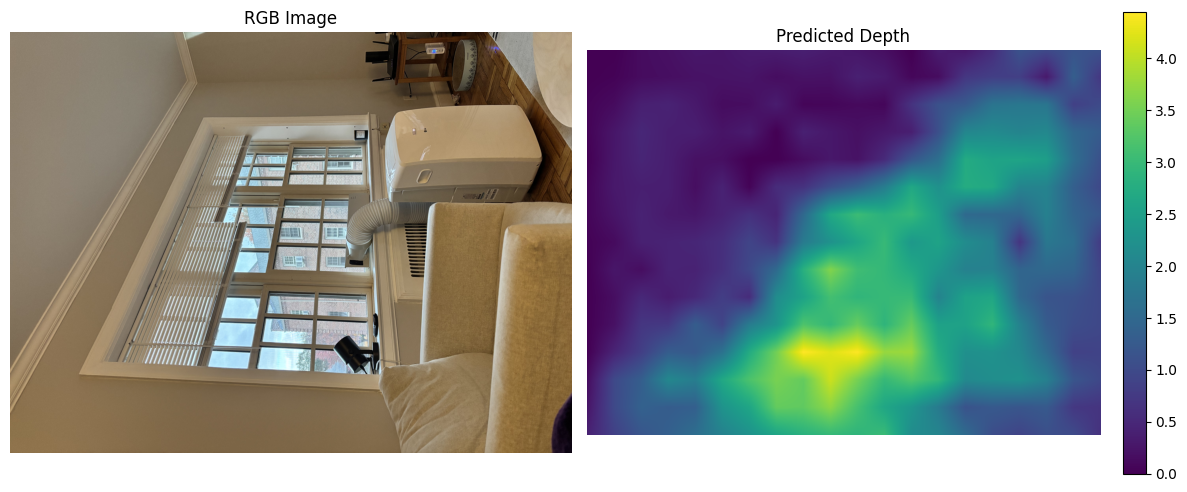

Saved prediction_1.png

Processing sample 2/15...


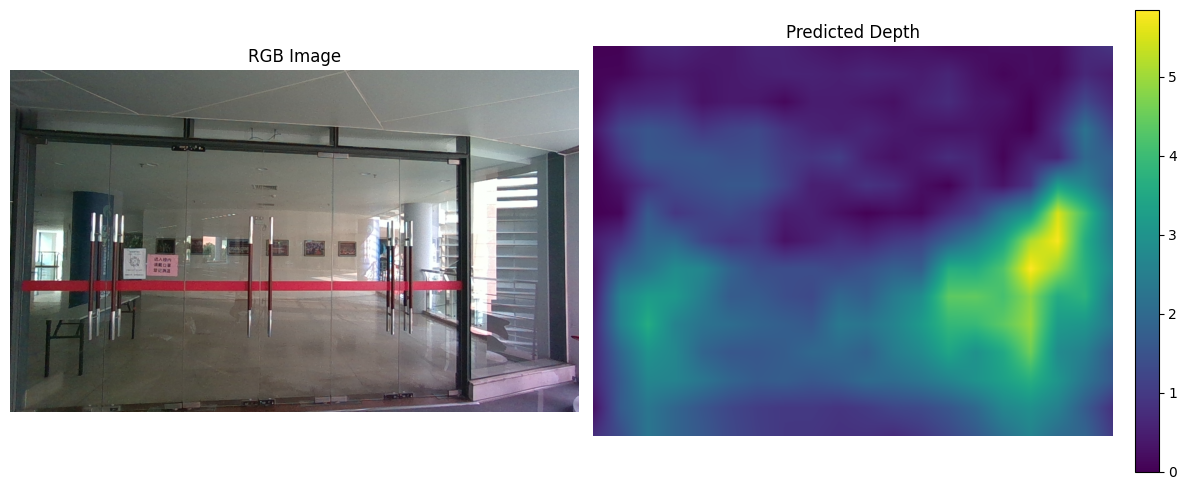

Saved prediction_2.png

Processing sample 3/15...


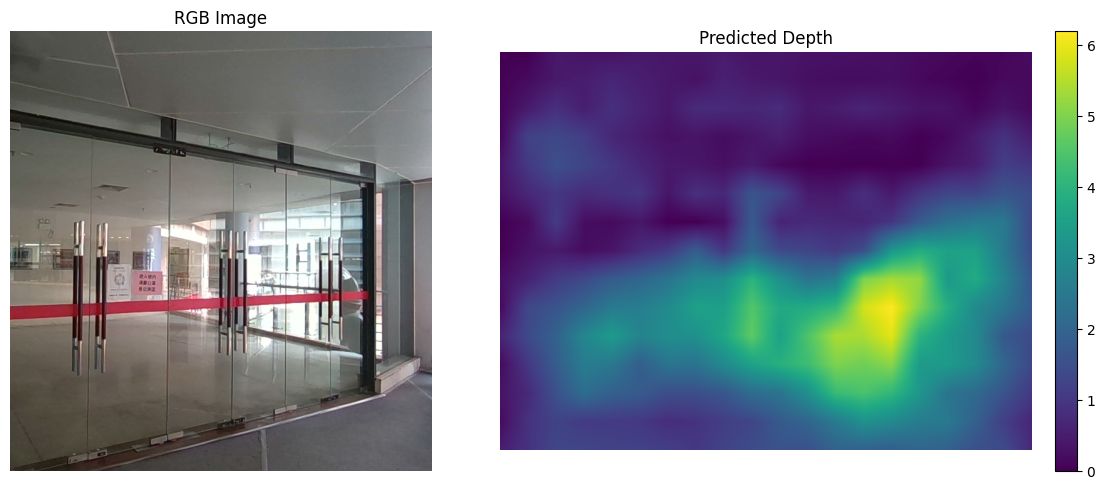

Saved prediction_3.png

Processing sample 4/15...


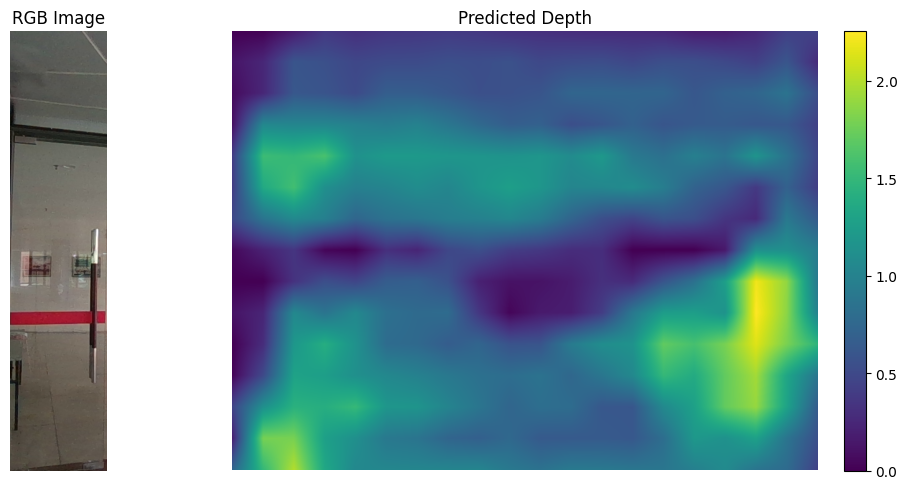

Saved prediction_4.png

Processing sample 5/15...


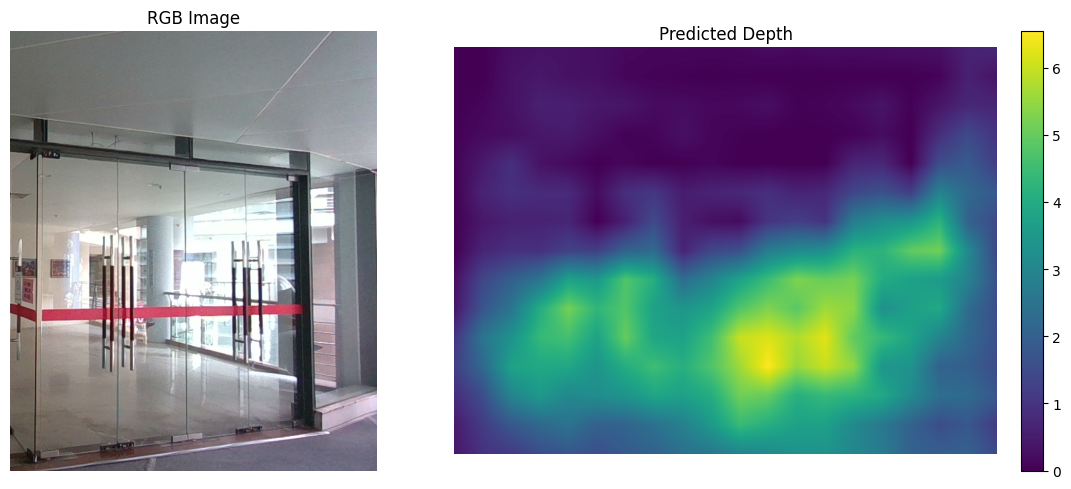

Saved prediction_5.png

Processing sample 6/15...


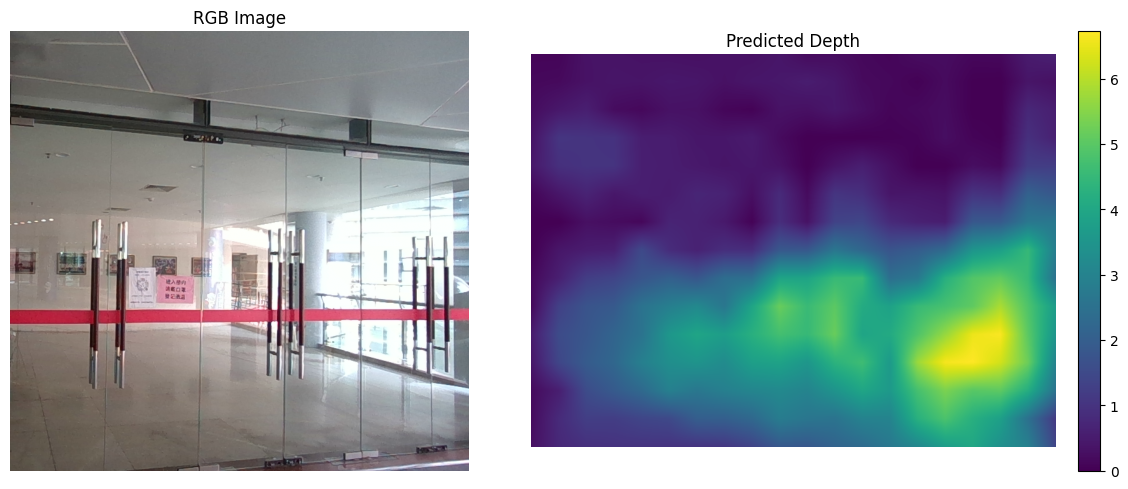

Saved prediction_6.png

Processing sample 7/15...


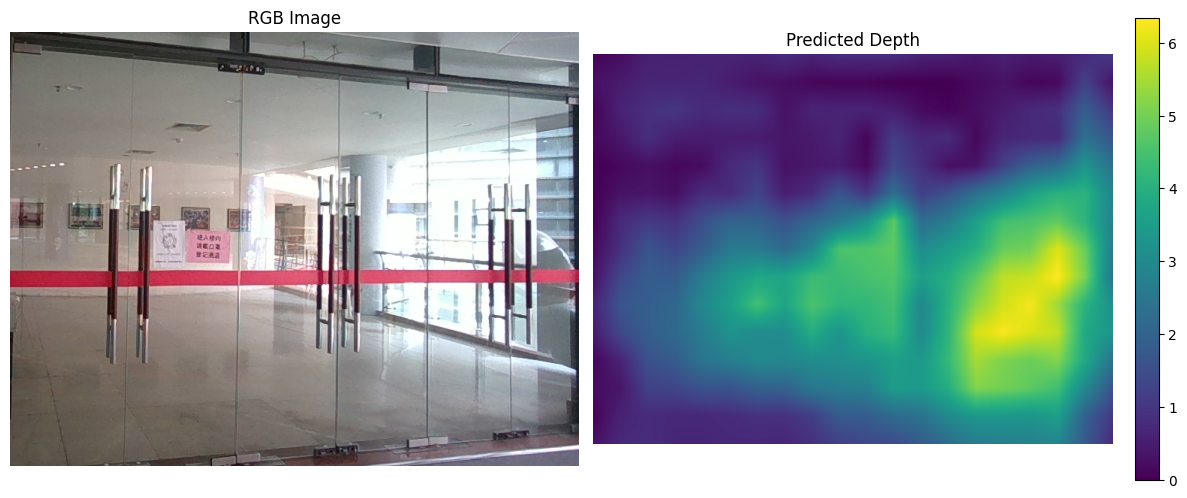

Saved prediction_7.png

Processing sample 8/15...


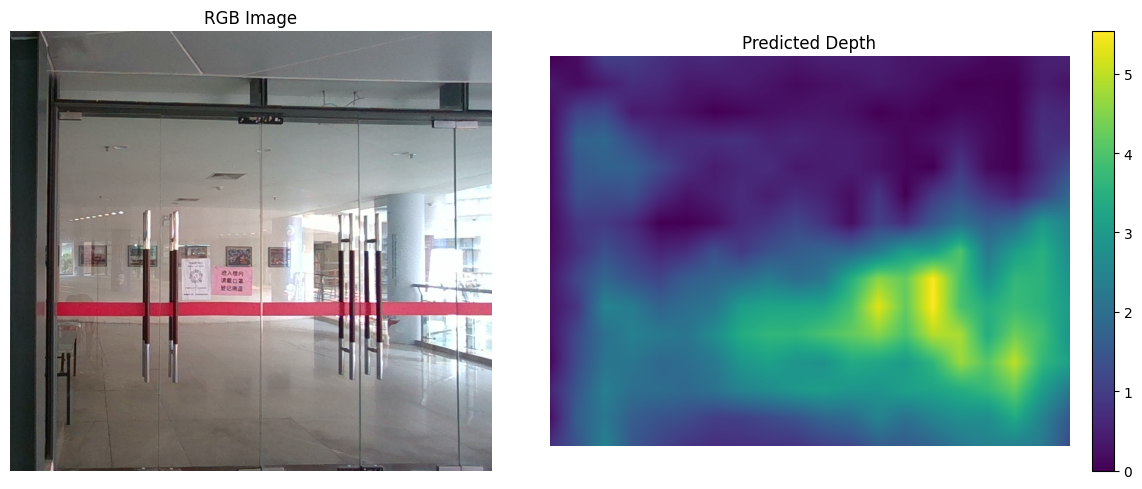

Saved prediction_8.png

Processing sample 9/15...


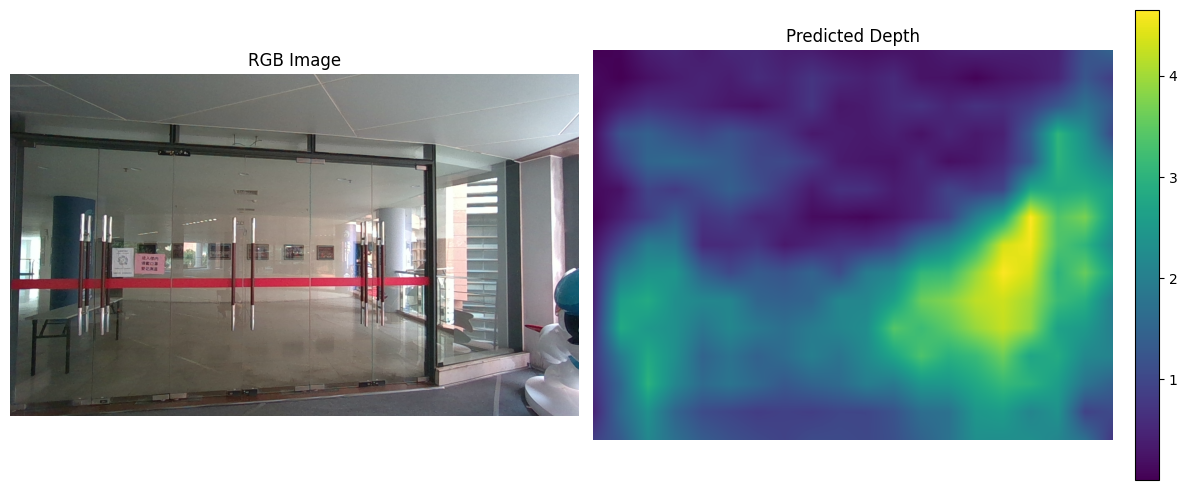

Saved prediction_9.png

Processing sample 10/15...


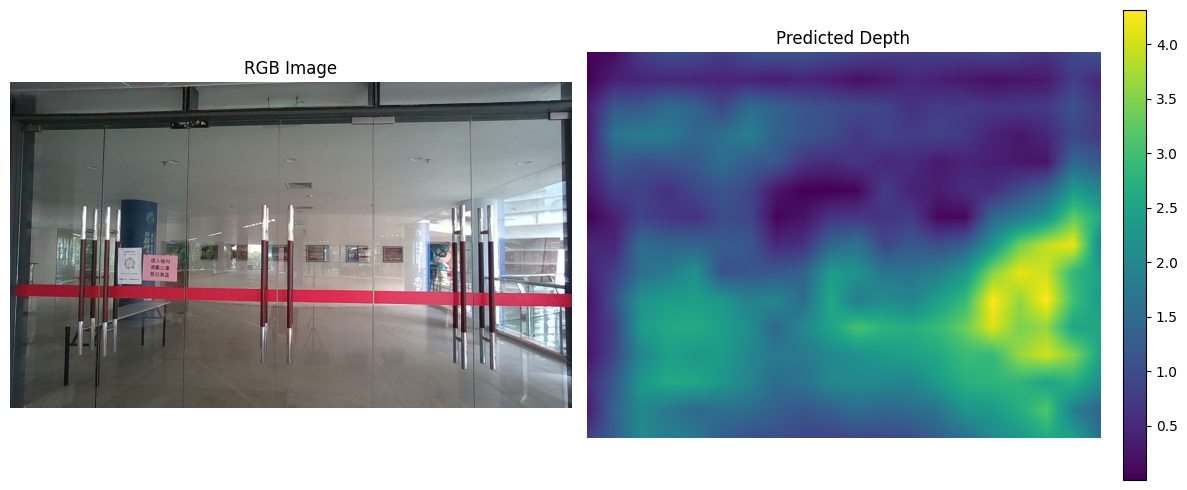

Saved prediction_10.png

Processing sample 11/15...


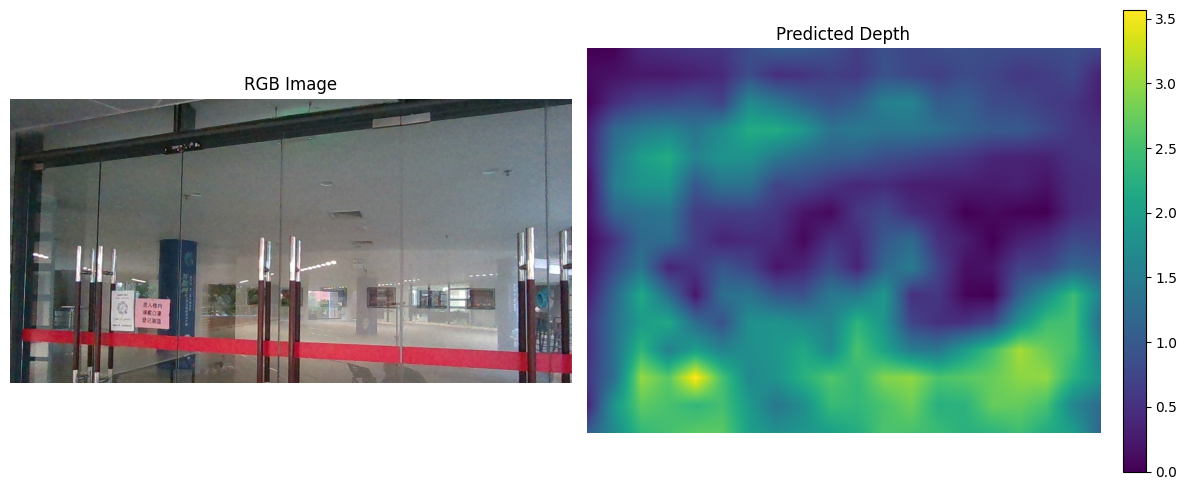

Saved prediction_11.png

Processing sample 12/15...


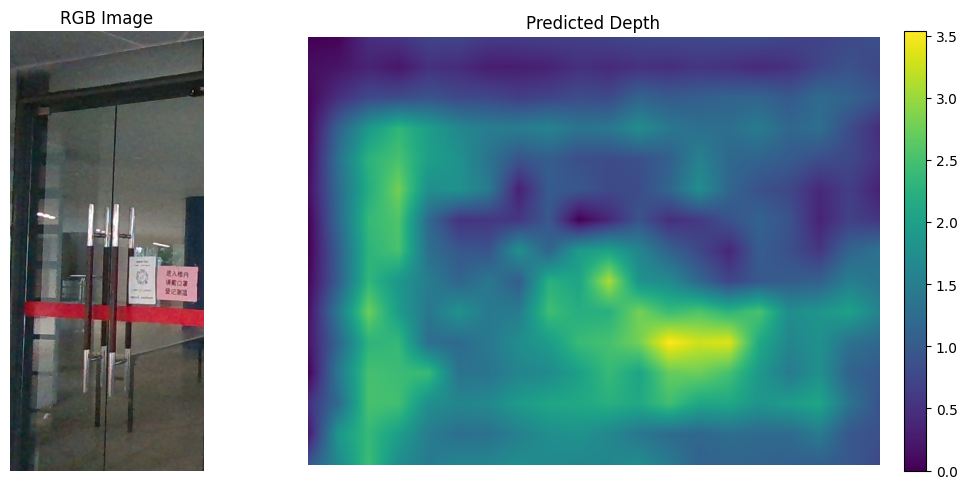

Saved prediction_12.png

Processing sample 13/15...


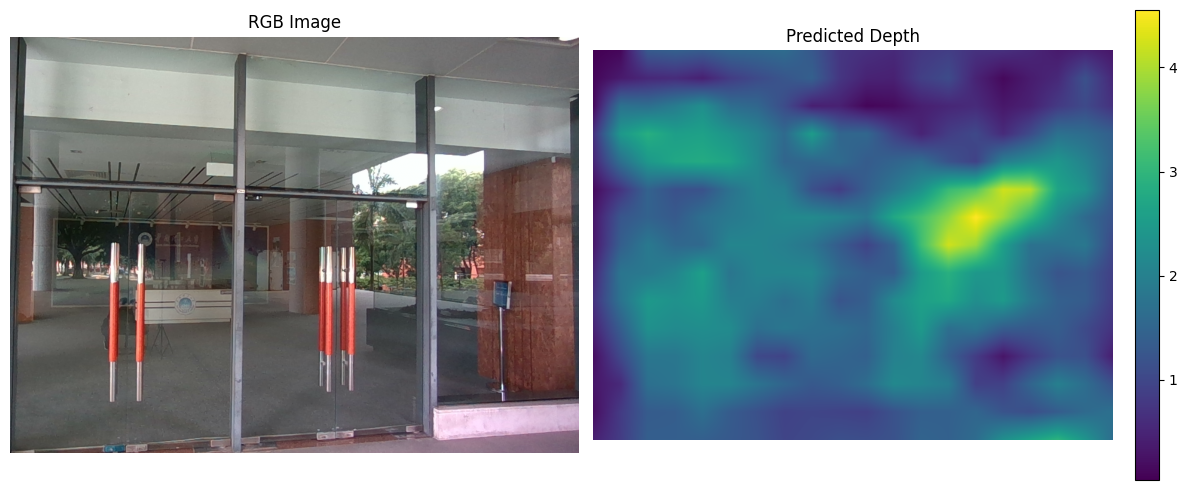

Saved prediction_13.png

Processing sample 14/15...


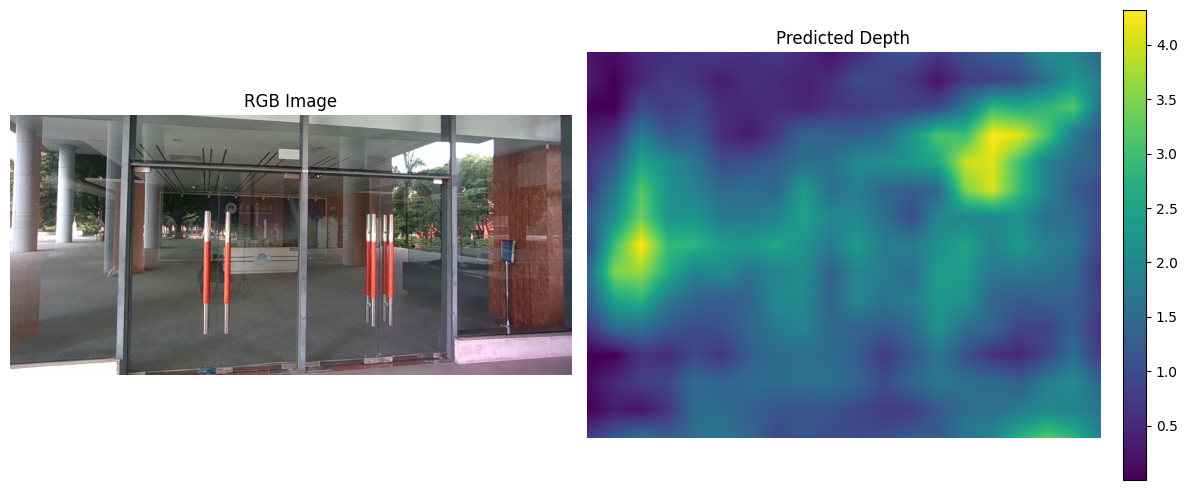

Saved prediction_14.png

Processing sample 15/15...


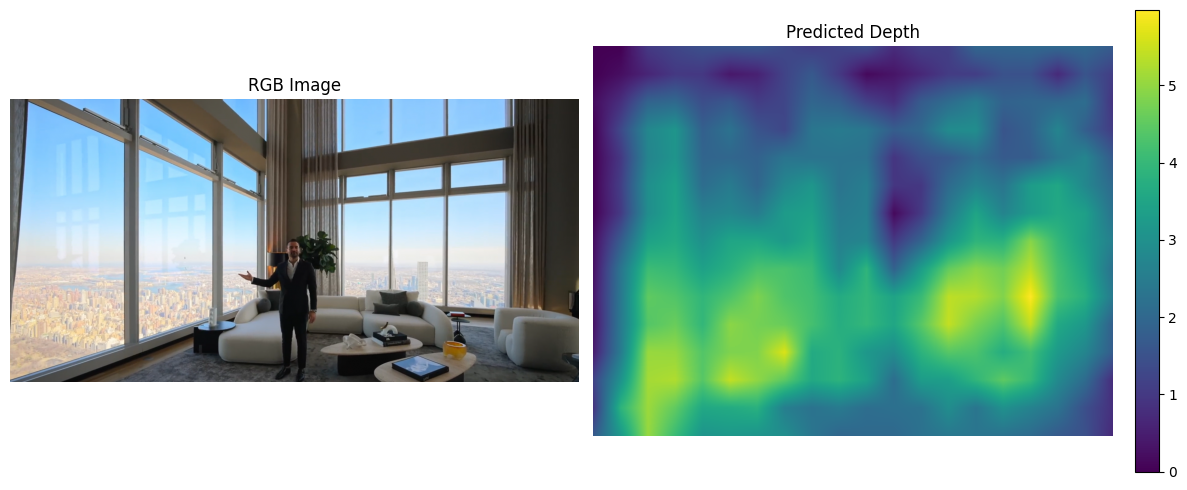

Saved prediction_15.png


In [35]:
DATASET_DIR = "./test_images"  # Path to your unzipped dataset
MODEL_PATH = "./checkpoint0100.pth"  # Path to your .pth file
    
# Check if paths exist
if Path(DATASET_DIR).exists() and Path(MODEL_PATH).exists():
    run_inference(DATASET_DIR, MODEL_PATH, num_samples=15)
else:
    print("\nPlease update the paths in the code:")
    print(f"   DATASET_DIR = '{DATASET_DIR}' (exists: {Path(DATASET_DIR).exists()})")
    print(f"   MODEL_PATH = '{MODEL_PATH}' (exists: {Path(MODEL_PATH).exists()})")

## Try doing detection on saved video

In [ ]:
import os
import sys
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pathlib import Path
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')


class GWDepthVideoProcessor:
    """
    Process videos through GW-Depth model for depth estimation
    """
    
    def __init__(self, model_path, device='cuda', input_size=(480, 640)):
        """
        Initialize the video processor
        
        Args:
            model_path: Path to the .pth model file
            device: Device to run inference on ('cuda' or 'cpu')
            input_size: Input size for the model (height, width)
        """
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.input_size = input_size
        
        print(f"Initializing GW-Depth Video Processor")
        print(f"Device: {self.device}")
        print(f"Input size: {input_size}")
        
        # Load the model
        self.model = self._load_model(model_path)
        
        # Setup transforms
        self.transform = transforms.Compose([
            transforms.Resize(input_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def _load_model(self, model_path):
        """Load the pretrained model"""
        model_path = Path(model_path)
        
        if not model_path.exists():
            print(f"[Error] Model file not found: {model_path}")
        
        try:
            # Load checkpoint
            checkpoint = torch.load(model_path, map_location=self.device, weights_only=False)
            
            # Create model architecture
            model = self._create_depth_model()
            
            # Load weights
            if isinstance(checkpoint, dict):
                if 'model_state_dict' in checkpoint:
                    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
                elif 'state_dict' in checkpoint:
                    model.load_state_dict(checkpoint['state_dict'], strict=False)
                elif 'model' in checkpoint:
                    model.load_state_dict(checkpoint['model'], strict=False)
            else:
                model.load_state_dict(checkpoint, strict=False)
            
            model.eval()
            print("Model loaded successfully")
            return model.to(self.device)
            
        except Exception as e:
            print(f"[Error] loading model: {e}")
    
    def _create_depth_model(self):
        """Create the depth estimation model architecture"""
        import torchvision.models as models
        
        class DepthEstimationModel(nn.Module):
            def __init__(self):
                super().__init__()
                # Use ResNet50 as backbone
                resnet = models.resnet50(pretrained=True)
                
                # Encoder
                self.encoder1 = nn.Sequential(*list(resnet.children())[:3])  # 64 channels
                self.encoder2 = nn.Sequential(*list(resnet.children())[3:5])  # 256 channels
                self.encoder3 = resnet.layer2  # 512 channels
                self.encoder4 = resnet.layer3  # 1024 channels
                self.encoder5 = resnet.layer4  # 2048 channels
                
                # Decoder with skip connections
                self.decoder5 = nn.Conv2d(2048, 1024, 3, padding=1)
                self.decoder4 = nn.Conv2d(1024 + 1024, 512, 3, padding=1)
                self.decoder3 = nn.Conv2d(512 + 512, 256, 3, padding=1)
                self.decoder2 = nn.Conv2d(256 + 256, 128, 3, padding=1)
                self.decoder1 = nn.Conv2d(128 + 64, 64, 3, padding=1)
                
                # Final depth prediction
                self.depth_pred = nn.Conv2d(64, 1, 3, padding=1)
                
                # Activation
                self.relu = nn.ReLU(inplace=True)
                
            def forward(self, x):
                # Encoder
                e1 = self.encoder1(x)
                e2 = self.encoder2(e1)
                e3 = self.encoder3(e2)
                e4 = self.encoder4(e3)
                e5 = self.encoder5(e4)
                
                # Decoder with upsampling and skip connections
                d5 = self.relu(self.decoder5(e5))
                d5_up = nn.functional.interpolate(d5, size=e4.shape[2:], mode='bilinear', align_corners=True)
                
                d4 = self.relu(self.decoder4(torch.cat([d5_up, e4], dim=1)))
                d4_up = nn.functional.interpolate(d4, size=e3.shape[2:], mode='bilinear', align_corners=True)
                
                d3 = self.relu(self.decoder3(torch.cat([d4_up, e3], dim=1)))
                d3_up = nn.functional.interpolate(d3, size=e2.shape[2:], mode='bilinear', align_corners=True)
                
                d2 = self.relu(self.decoder2(torch.cat([d3_up, e2], dim=1)))
                d2_up = nn.functional.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=True)
                
                d1 = self.relu(self.decoder1(torch.cat([d2_up, e1], dim=1)))
                
                # Final depth prediction
                depth = self.depth_pred(d1)
                depth = nn.functional.interpolate(depth, size=x.shape[2:], mode='bilinear', align_corners=True)
                depth = torch.relu(depth)  # Ensure positive depth
                
                return depth
        
        return DepthEstimationModel()

    
    def process_frame(self, frame):
        """
        Process a single frame to estimate depth
        
        Args:
            frame: Input frame (numpy array, BGR format from OpenCV)
        
        Returns:
            depth_map: Estimated depth map (numpy array)
        """
        # Convert BGR to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Convert to PIL Image
        pil_image = Image.fromarray(rgb_frame)
        
        # Apply transforms
        input_tensor = self.transform(pil_image).unsqueeze(0).to(self.device)
        
        # Run inference
        with torch.no_grad():
            depth_pred = self.model(input_tensor)
        
        # Convert to numpy and resize to original size
        depth_map = depth_pred.squeeze().cpu().numpy()
        depth_map = cv2.resize(depth_map, (frame.shape[1], frame.shape[0]), 
                               interpolation=cv2.INTER_LINEAR)
        
        return depth_map
    
    def process_video(self, input_path, output_path, 
                     visualization='side_by_side',
                     max_frames=None,
                     fps=None,
                     show_progress=True):
        """
        Process video file
        
        Args:
            input_path: Path to input video
            output_path: Path to output video
            visualization: Type of visualization 
                          ('side_by_side', 'overlay', 'depth_only', 'three_panel')
            max_frames: Maximum number of frames to process (None for all)
            fps: Output video FPS (None to use input video FPS)
            show_progress: Show progress bar
        
        Returns:
            processing_stats: Dictionary with processing statistics
        """
        print(f"\nProcessing video: {input_path}")
        
        # Open input video
        cap = cv2.VideoCapture(str(input_path))
        
        # Get video properties
        input_fps = int(cap.get(cv2.CAP_PROP_FPS))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        
        if fps is None:
            fps = input_fps
        
        if max_frames:
            total_frames = min(total_frames, max_frames)
        
        print(f"   Input: {width}x{height} @ {input_fps} FPS, {total_frames} frames")
        
        # Setup output video
        output_width, output_height = self._get_output_size(width, height, visualization)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(str(output_path), fourcc, fps, (output_width, output_height))
        
        print(f"   Output: {output_width}x{output_height} @ {fps} FPS")
        print(f"   Visualization: {visualization}")
        
        # Process frames
        frame_count = 0
        processing_times = []
        
        # Progress bar
        pbar = tqdm(total=total_frames, desc="Processing frames") if show_progress else None
        
        while True:
            ret, frame = cap.read()
            if not ret or (max_frames and frame_count >= max_frames):
                break
            
            # Process frame
            start_time = time.time()
            depth_map = self.process_frame(frame)
            processing_time = time.time() - start_time
            processing_times.append(processing_time)
            
            # Create visualization
            output_frame = self._create_visualization(frame, depth_map, visualization)
            
            # Write frame
            out.write(output_frame)
            
            frame_count += 1
            if pbar:
                pbar.update(1)
                pbar.set_postfix({'FPS': f"{1/processing_time:.1f}"})
        
        # Cleanup
        cap.release()
        out.release()
        if pbar:
            pbar.close()
        
        # Calculate statistics
        stats = {
            'frames_processed': frame_count,
            'avg_fps': 1 / np.mean(processing_times),
            'total_time': sum(processing_times),
            'output_path': output_path
        }
        
        print(f"\nVideo processing complete!")
        print(f"Frames processed: {stats['frames_processed']}")
        print(f"Average FPS: {stats['avg_fps']:.1f}")
        print(f"Total time: {stats['total_time']:.1f}s")
        print(f"Output saved to: {output_path}")
        
        return stats
    
    def _get_output_size(self, width, height, visualization):
        """Get output video dimensions based on visualization type"""
        if visualization == 'side_by_side':
            return width * 2, height
        elif visualization == 'three_panel':
            return width * 3, height
        elif visualization == 'overlay' or visualization == 'depth_only':
            return width, height
        else:
            return width, height
    
    def _create_visualization(self, frame, depth_map, visualization):
        """Create visualization of RGB frame and depth map"""
        
        # Normalize depth for visualization
        depth_normalized = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min() + 1e-8)
        
        # Apply colormap to depth
        depth_colored = (cm.viridis(depth_normalized)[:, :, :3] * 255).astype(np.uint8)
        depth_colored_bgr = cv2.cvtColor(depth_colored, cv2.COLOR_RGB2BGR)
        
        if visualization == 'side_by_side':
            # Place RGB and depth side by side
            output = np.hstack([frame, depth_colored_bgr])
            
        elif visualization == 'overlay':
            # Overlay depth on RGB with transparency
            alpha = 0.4
            output = cv2.addWeighted(frame, 1-alpha, depth_colored_bgr, alpha, 0)
            
        elif visualization == 'depth_only':
            # Only show depth map
            output = depth_colored_bgr
            
        elif visualization == 'three_panel':
            # Show RGB, depth, and overlay
            overlay = cv2.addWeighted(frame, 0.6, depth_colored_bgr, 0.4, 0)
            output = np.hstack([frame, depth_colored_bgr, overlay])
            
        else:
            output = frame
        
        # Add text labels
        if visualization in ['side_by_side', 'three_panel']:
            cv2.putText(output, 'RGB', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                       1, (255, 255, 255), 2)
            cv2.putText(output, 'Depth', (frame.shape[1] + 10, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            
            if visualization == 'three_panel':
                cv2.putText(output, 'Overlay', (frame.shape[1]*2 + 10, 30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        
        return output
    
    def process_webcam(self, visualization='side_by_side', record=False, output_path=None):
        """
        Process real-time webcam feed
        
        Args:
            visualization: Type of visualization
            record: Whether to record the output
            output_path: Path to save recorded video
        """
        print("\n📷 Starting webcam processing...")
        print("   Press 'q' to quit")
        print("   Press 's' to save current frame")
        print("   Press 'v' to cycle through visualizations")
        
        # Visualization modes
        viz_modes = ['side_by_side', 'overlay', 'depth_only', 'three_panel']
        current_viz_idx = viz_modes.index(visualization)
        
        # Open webcam
        cap = cv2.VideoCapture(0)
        
        # Get webcam properties
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        
        # Setup recording if requested
        out = None
        if record and output_path:
            output_width, output_height = self._get_output_size(width, height, visualization)
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(str(output_path), fourcc, fps, (output_width, output_height))
            print(f"   Recording to: {output_path}")
        
        frame_count = 0
        fps_list = []
        
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Process frame
            start_time = time.time()
            depth_map = self.process_frame(frame)
            fps_current = 1 / (time.time() - start_time)
            fps_list.append(fps_current)
            
            # Keep rolling average of FPS
            if len(fps_list) > 30:
                fps_list.pop(0)
            avg_fps = np.mean(fps_list)
            
            # Create visualization
            current_viz = viz_modes[current_viz_idx]
            output_frame = self._create_visualization(frame, depth_map, current_viz)
            
            # Add FPS counter
            cv2.putText(output_frame, f'FPS: {avg_fps:.1f}', 
                       (output_frame.shape[1] - 120, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
            
            # Show frame
            cv2.imshow('GW-Depth Webcam', output_frame)
            
            # Record if enabled
            if out:
                out.write(output_frame)
            
            # Handle keyboard input
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                break
            elif key == ord('s'):
                # Save current frame
                save_path = f'webcam_frame_{frame_count}.png'
                cv2.imwrite(save_path, output_frame)
                print(f"   Saved frame to: {save_path}")
            elif key == ord('v'):
                # Cycle through visualization modes
                current_viz_idx = (current_viz_idx + 1) % len(viz_modes)
                print(f"   Switched to: {viz_modes[current_viz_idx]}")
            
            frame_count += 1
        
        # Cleanup
        cap.release()
        if out:
            out.release()
        cv2.destroyAllWindows()
        
        print(f"\nWebcam processing stopped")
        print(f"   Frames processed: {frame_count}")
        print(f"   Average FPS: {avg_fps:.1f}")

In [ ]:
print("GW-DEPTH VIDEO PROCESSING")

# Path configs
MODEL_PATH = "./checkpoint0100.pth"  # Path to your .pth file
INPUT_VIDEO = "./video/tour_one.mp4"      # Path to your input video
OUTPUT_VIDEO = "./video/tour_one_depth.mp4"    # Path to save output video

# Check if files exist
model_exists = Path(MODEL_PATH).exists()
video_exists = Path(INPUT_VIDEO).exists()

print(f"\nConfiguration:")
print(f"   Model: {MODEL_PATH} (exists: {model_exists})")
print(f"   Input: {INPUT_VIDEO} (exists: {video_exists})")
print(f"   Output: {OUTPUT_VIDEO}")

if not model_exists:
    print("\n[Error] Model file not found!")

# Initialize processor
processor = GWDepthVideoProcessor(MODEL_PATH)

if video_exists:
    print("\nProcessing video file...")
    stats = processor.process_video(
        INPUT_VIDEO,
        OUTPUT_VIDEO,
        visualization='side_by_side',  # or 'overlay', 'depth_only', 'three_panel'
        max_frames=None,  # Process all frames
        fps=None,
        show_progress=True
    )
else:
    print("\n[Error] No input video found. Need to update INPUT_VIDEO path.")

GW-DEPTH VIDEO PROCESSING

Configuration:
   Model: ./checkpoint0100.pth (exists: True)
   Input: ./video/tour_one.mp4 (exists: True)
   Output: ./video/tour_one_depth.mp4


NameError: name 'GWDepthVideoProcessor' is not defined

## Try doing on live video

In [ ]:
processor.process_webcam(
    visualization='side_by_side',
    record=True,
    output_path='webcam_recording.mp4'
)

# Key Related Work
MonoGlass3D: Monocular 3D Glass Detection with Plane Regression and Adaptive Feature Fusion

https://arxiv.org/pdf/2509.05599


Monocular Depth Estimation for Glass Walls With Context: A New Dataset and Method

https://orca.cardiff.ac.uk/id/eprint/161953/1/paper.pdf


Video Clips from: Inside the MOST EXPENSIVE and HIGHEST Penthouse In the WORLD!

https://youtu.be/aN9DH_GxqEo?si=hOPEKFJ9GbDRAX2E